In [9]:
from omegaconf import OmegaConf
from models.softsplat import softsplat
from ldm.util import instantiate_from_config
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import matplotlib.pyplot as plt
import flowiz as fz
from src.train.util import *
import cv2

In [2]:
path = 'configs/uni_wrap/local_v15.yaml'
config = OmegaConf.load(path)
dataset = instantiate_from_config(config['data'])
print('DATA SET LENGTH ', len(dataset))

/home/maryam.sana/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DATA SET LENGTH  683828


In [3]:
print(len(dataset.sequences), len(dataset.video_frames))

129291 683828


In [7]:
target_path = '/data2/local_datasets/vimeo_sequences/00009/0980/im3.png'
ref_path = '/data2/local_datasets/vimeo_sequences/00009/0980/r1.png'
flow_path = '/data2/local_datasets/vimeo_sequences/00009/0980/Flow/im3.flo'

image = cv2.imread(target_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

ref = cv2.imread(ref_path)
ref= cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)

flow = load_flo_file(flow_path)
flow = adaptive_weighted_downsample(flow, target_h=128, target_w=128)

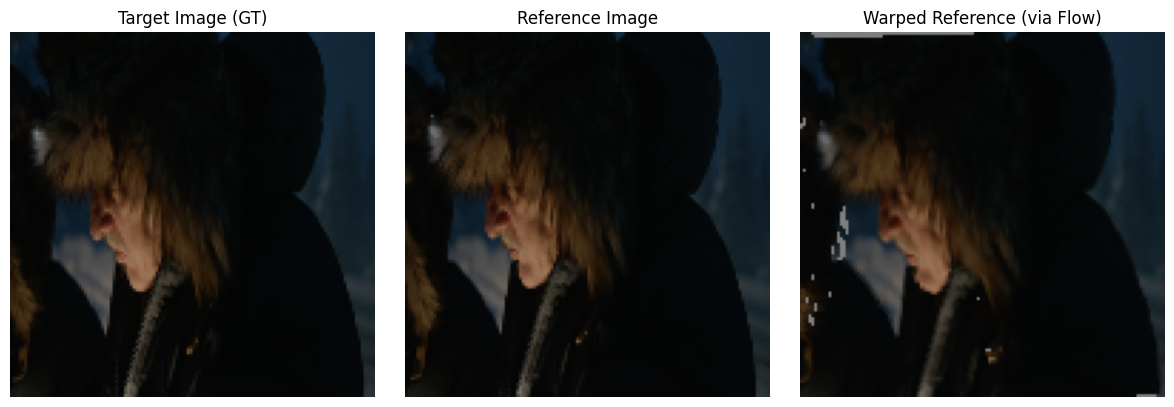

In [13]:
image_resized = cv2.resize(image, (128, 128), interpolation=cv2.INTER_LINEAR)
ref_resized = cv2.resize(ref, (128, 128), interpolation=cv2.INTER_LINEAR)

# --- Convert to torch tensors ---
to_tensor = transforms.ToTensor()  # Converts to [0,1], shape [C, H, W]
ref_tensor = to_tensor(ref_resized).unsqueeze(0).cuda() * 2 - 1  # [1, 3, 128, 128], [-1, 1]
image_tensor = to_tensor(image_resized).unsqueeze(0).cuda() * 2 - 1

flow_tensor = torch.from_numpy(flow).permute(2, 0, 1).unsqueeze(0).float().cuda()  # [1, 2, 128, 128]

# --- Metric mask (confidence map) — just ones for now ---
metric = torch.ones_like(ref_tensor[:, :1, :, :])

# --- Warp the reference frame using SoftSplat and flow ---
warped = softsplat(tenIn=ref_tensor, tenFlow=flow_tensor, tenMetric=metric, strMode='soft')

# --- Convert for visualization ---
image_np = ((image_tensor.squeeze().cpu() + 1) / 2).permute(1, 2, 0).numpy()
ref_np = ((ref_tensor.squeeze().cpu() + 1) / 2).permute(1, 2, 0).numpy()
warped_np = warped.squeeze().clamp(-1, 1)
warped_np = ((warped_np.cpu() + 1) / 2).permute(1, 2, 0).detach().numpy()

# --- Plot results ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Target Image (GT)")
plt.imshow(image_np)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Reference Image")
plt.imshow(ref_np)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Warped Reference (via Flow)")
plt.imshow(warped_np)
plt.axis("off")

plt.tight_layout()
plt.show()